# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from tensorflow import keras
# from tensorflow.keras import *
import warnings
warnings.filterwarnings('ignore')


# Exploratory Data Analysis (EDA)

## Import Datasets

In [2]:
dataset_path = 'Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        # Store the label for the image in the labels list
        labels.append(subfolder)
 
 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

## Understanding the dataset

In [3]:
print(df.head())
print(df.tail())

                                            image    label
0      Rice_Image_Dataset\Arborio\Arborio (1).jpg  Arborio
1     Rice_Image_Dataset\Arborio\Arborio (10).jpg  Arborio
2    Rice_Image_Dataset\Arborio\Arborio (100).jpg  Arborio
3   Rice_Image_Dataset\Arborio\Arborio (1000).jpg  Arborio
4  Rice_Image_Dataset\Arborio\Arborio (10000).jpg  Arborio
                                                   image      label
74995  Rice_Image_Dataset\Karacadag\Karacadag (9995).jpg  Karacadag
74996  Rice_Image_Dataset\Karacadag\Karacadag (9996).jpg  Karacadag
74997  Rice_Image_Dataset\Karacadag\Karacadag (9997).jpg  Karacadag
74998  Rice_Image_Dataset\Karacadag\Karacadag (9998).jpg  Karacadag
74999  Rice_Image_Dataset\Karacadag\Karacadag (9999).jpg  Karacadag


In [4]:
# Basic information
print(df.info())

# Summary statistics
print(df.describe())

# Count of images per label
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   75000 non-null  object
 1   label   75000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
                                             image    label
count                                        75000    75000
unique                                       75000        5
top     Rice_Image_Dataset\Arborio\Arborio (1).jpg  Arborio
freq                                             1    15000
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: label, dtype: int64


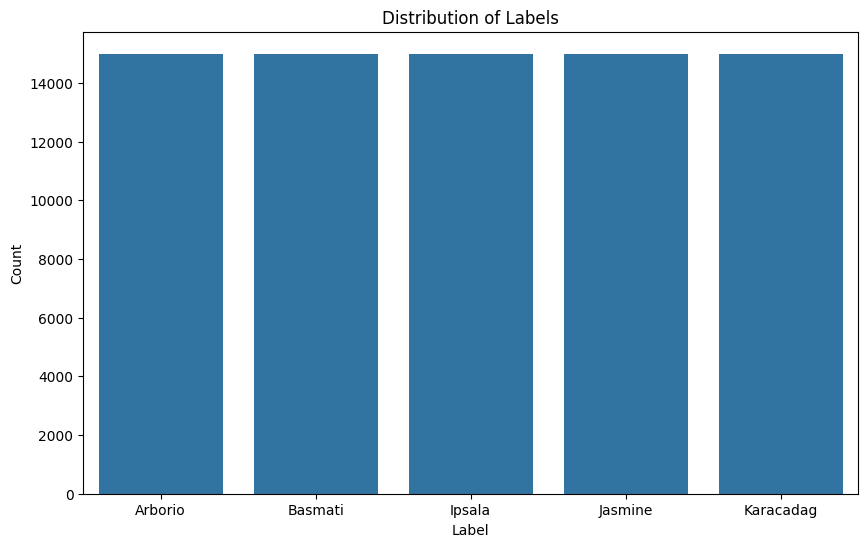

In [5]:
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


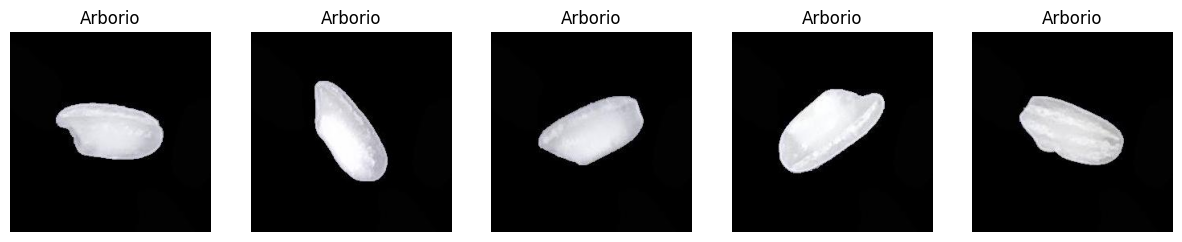

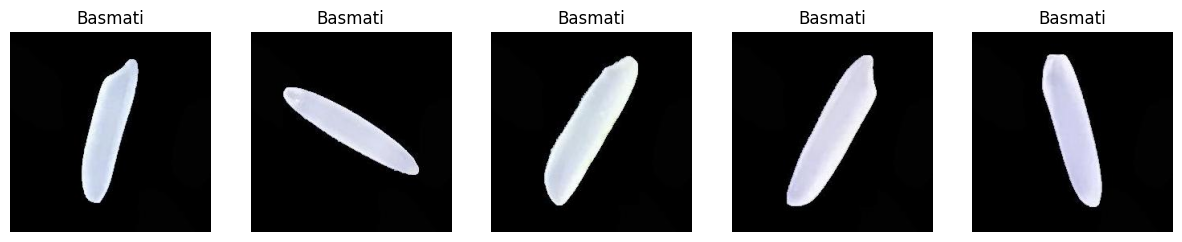

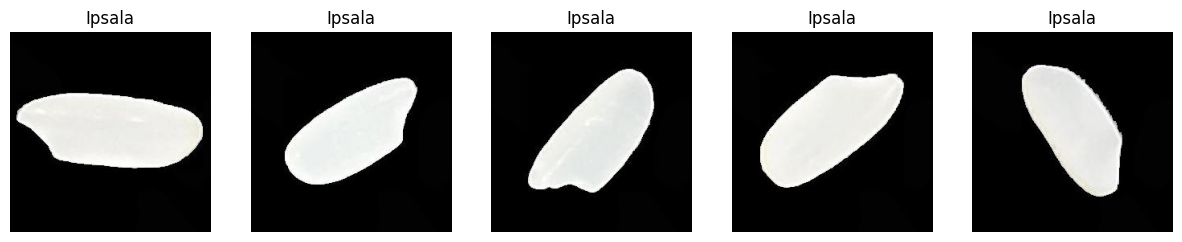

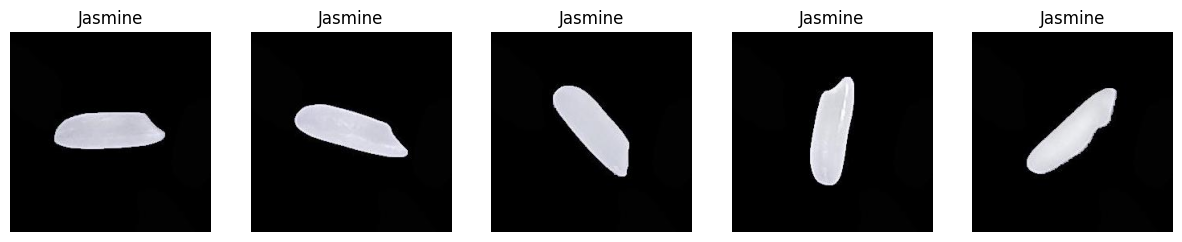

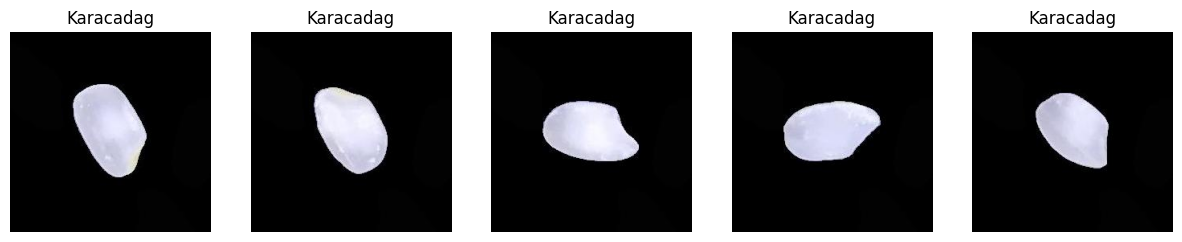

In [6]:
# Function to display images
def display_images(df, label, num_images=5):
    images = df[df['label'] == label]['image'].values[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(images):
        img = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Display sample images for each label
for label in df['label'].unique():
    display_images(df, label)


## Explore more about the dataset

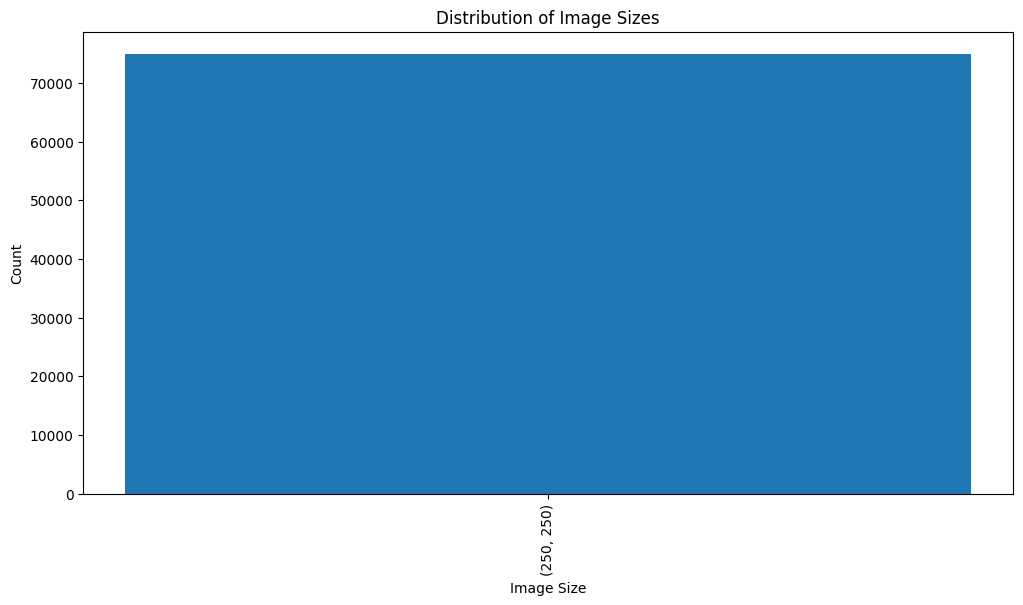

In [7]:
# Function to get image sizes
def get_image_size(image_path):
    img = Image.open(image_path)
    return img.size

# Get sizes of all images
df['image_size'] = df['image'].apply(get_image_size)

# Display unique image sizes
image_size_counts = df['image_size'].value_counts().reset_index()
image_size_counts.columns = ['image_size', 'count']

# Plot image sizes using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(image_size_counts['image_size'].astype(str), image_size_counts['count'])
plt.title('Distribution of Image Sizes')
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


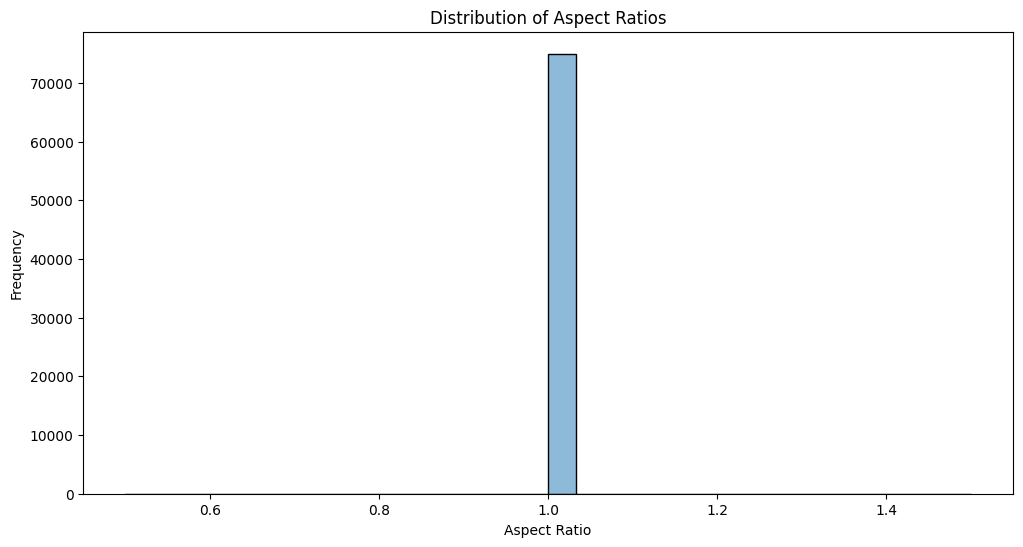

In [8]:
# Function to calculate aspect ratio
def get_aspect_ratio(image_path):
    img = Image.open(image_path)
    width, height = img.size
    return width / height

# Get aspect ratios of all images
df['aspect_ratio'] = df['image'].apply(get_aspect_ratio)

# Plot aspect ratio distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['aspect_ratio'], bins=30, kde=True)
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()


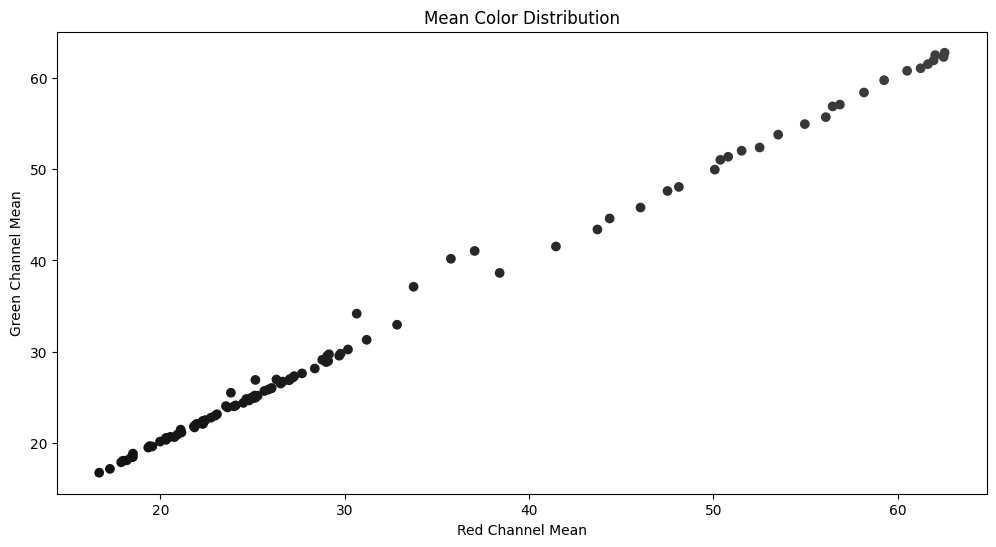

In [9]:
# Function to get mean color
def get_mean_color(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    return img.mean(axis=(0, 1))

# Get mean colors of a sample of images
sample_images = df.sample(100)['image']
mean_colors = np.array([get_mean_color(img) for img in sample_images])

# Plot mean colors
plt.figure(figsize=(12, 6))
plt.scatter(mean_colors[:, 0], mean_colors[:, 1], c=mean_colors / 255.0)
plt.title('Mean Color Distribution')
plt.xlabel('Red Channel Mean')
plt.ylabel('Green Channel Mean')
plt.show()


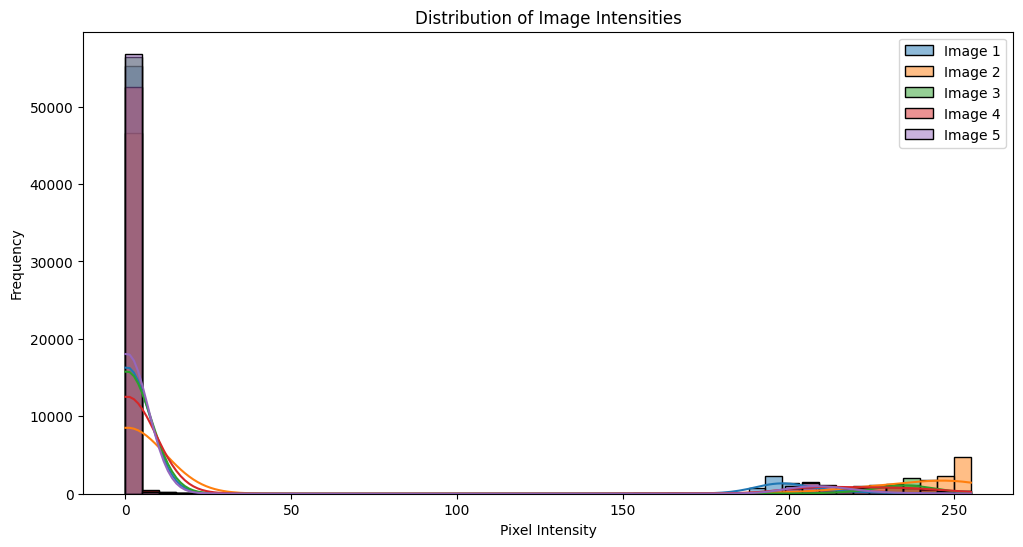

In [10]:
# Function to get image intensity distribution
def get_image_intensity(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(img).flatten()

# Get intensity distributions of a sample of images
sample_images = df.sample(100)['image']
intensity_distributions = np.array([get_image_intensity(img) for img in sample_images])

# Plot intensity distributions
plt.figure(figsize=(12, 6))
for i, intensity in enumerate(intensity_distributions[:5]):  # Plot first 5 images
    sns.histplot(intensity, bins=50, kde=True, label=f'Image {i+1}')
plt.title('Distribution of Image Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


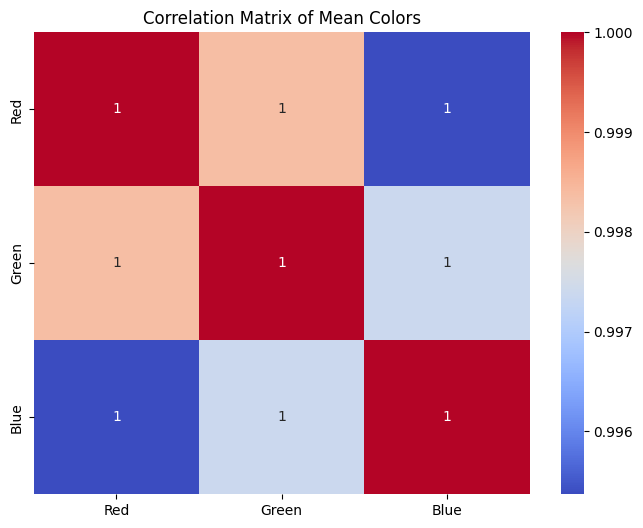

In [11]:
# Compute the correlation matrix
mean_colors_df = pd.DataFrame(mean_colors, columns=['Red', 'Green', 'Blue'])
correlation_matrix = mean_colors_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Mean Colors')
plt.show()


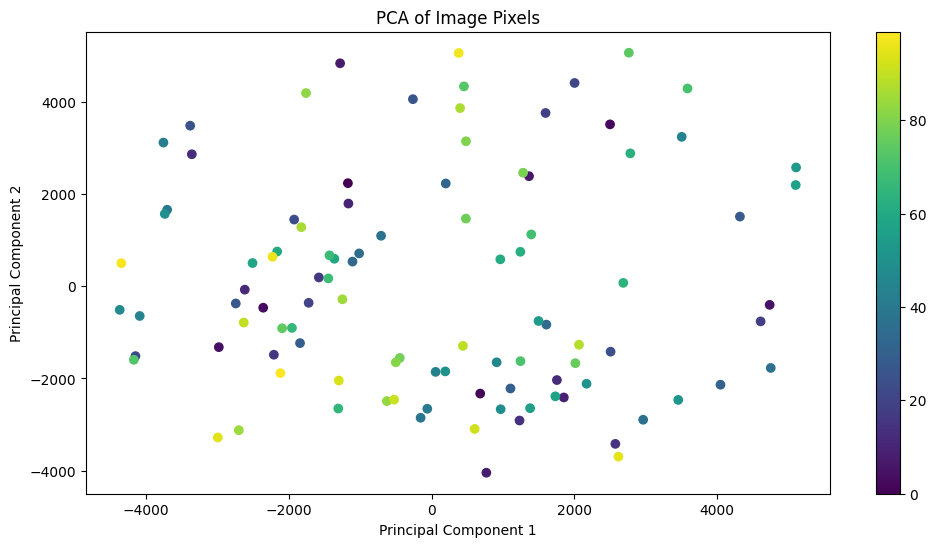

In [12]:
from sklearn.decomposition import PCA

# Function to get flattened pixel values
def get_flattened_pixels(image_path):
    img = Image.open(image_path)
    img = img.resize((64, 64))  # Resize for consistency
    return np.array(img).flatten()

# Get flattened pixel values for a sample of images
sample_images = df.sample(100)['image']
flattened_pixels = np.array([get_flattened_pixels(img) for img in sample_images])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_pixels)

# Plot the PCA result
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.arange(len(sample_images)), cmap='viridis')
plt.colorbar()
plt.title('PCA of Image Pixels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


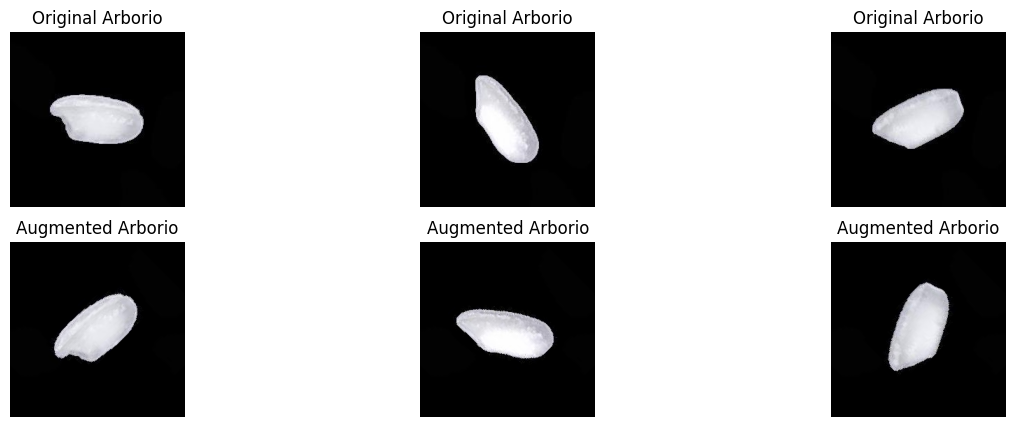

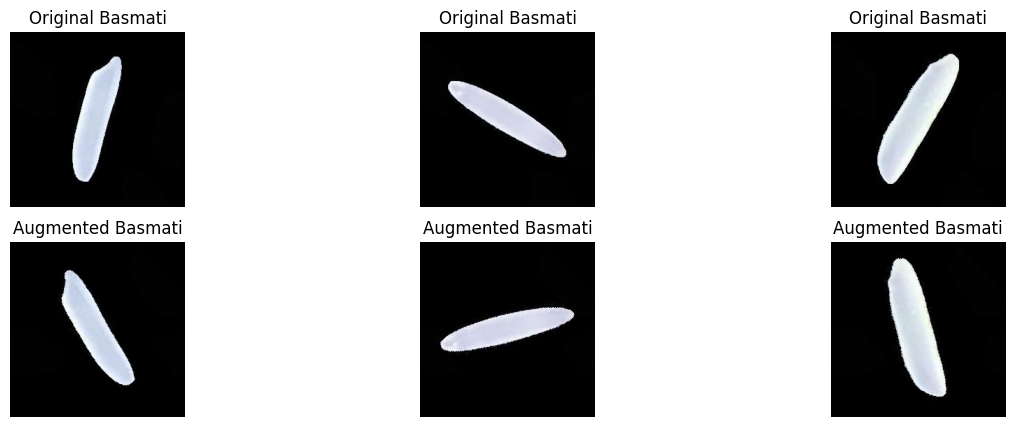

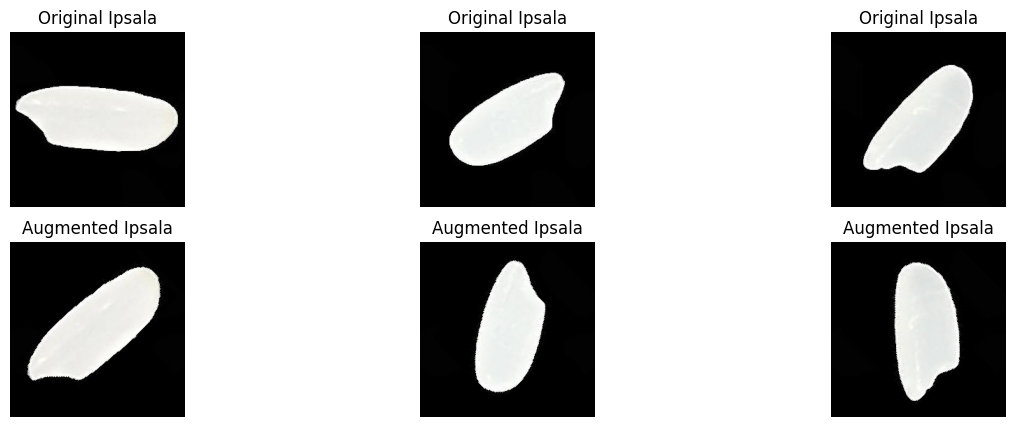

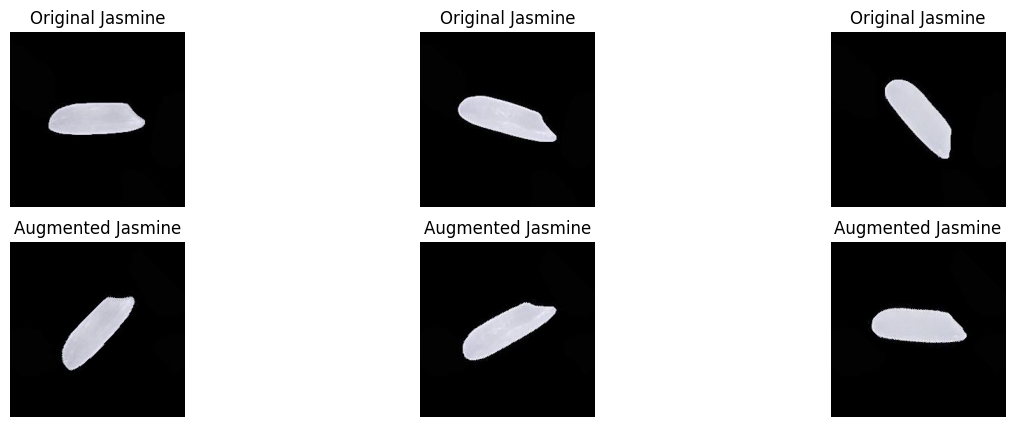

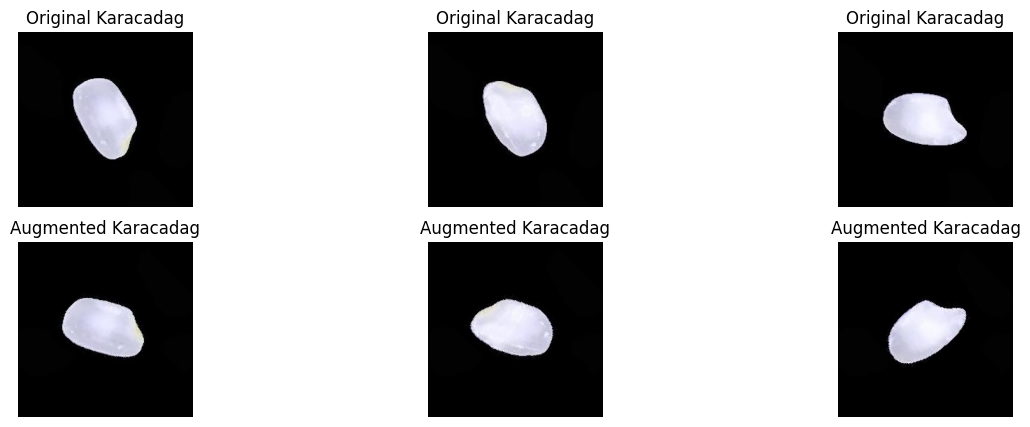

In [13]:
# Function to display original and augmented images
def display_augmented_images(df, label, num_images=3):
    images = df[df['label'] == label]['image'].values[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(images):
        img = Image.open(image_path)
        plt.subplot(2, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Original {label}')
        plt.axis('off')
        
        # Apply a simple augmentation (e.g., rotation)
        aug_img = img.rotate(45)
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(aug_img)
        plt.title(f'Augmented {label}')
        plt.axis('off')
    plt.show()

# Display original and augmented images for each label
for label in df['label'].unique():
    display_augmented_images(df, label)


## Data Preprocessing

In [14]:
# Function to resize images
def resize_image(image_path, size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(size)
    return np.array(img)

# Apply resizing to all images
df['image_resized'] = df['image'].apply(lambda x: resize_image(x))

In [15]:
# Function to normalize images
def normalize_image(image_array):
    return image_array / 255.0

# Apply normalization to resized images
df['image_normalized'] = df['image_resized'].apply(normalize_image)


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])


In [17]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f'Train set: {train_df.shape}')
print(f'Validation set: {val_df.shape}')
print(f'Test set: {test_df.shape}')

# Function to preprocess images
def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(size)
    img = np.array(img) / 255.0
    return img

# Data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, size=(128, 128), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.size = size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.size, 3))
        y = np.empty((self.batch_size), dtype=int)
        for i, (image_path, label) in enumerate(zip(batch_df['image'], batch_df['label_encoded'])):
            X[i,] = preprocess_image(image_path, self.size)
            y[i] = label
        y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))
        return X, y

# Create data generators
train_generator = DataGenerator(train_df, batch_size=32)
val_generator = DataGenerator(val_df, batch_size=32)
test_generator = DataGenerator(test_df, batch_size=32)

# Example of using the generators with a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


Train set: (52500, 7)
Validation set: (11250, 7)
Test set: (11250, 7)
Epoch 1/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 753s 456ms/step - accuracy: 0.9290 - loss: 0.2214 - val_accuracy: 0.9890 - val_loss: 0.0402
Epoch 2/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 279s 170ms/step - accuracy: 0.9874 - loss: 0.0395 - val_accuracy: 0.9869 - val_loss: 0.0370
Epoch 3/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 194s 118ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accuracy: 0.9897 - val_loss: 0.0340
Epoch 4/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 184s 112ms/step - accuracy: 0.9925 - loss: 0.0211 - val_accuracy: 0.9865 - val_loss: 0.0471
Epoch 5/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 175s 107ms/step - accuracy: 0.9938 - loss: 0.0163 - val_accuracy: 0.9885 - val_loss: 0.0375
Epoch 6/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 174s 106ms/step - accuracy: 0.9922 - loss: 0.0213 - val_accuracy: 0.9918 - val_loss: 0.0297
Epoch 7/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 172s 105ms/step - accuracy: 0.9966 - loss: 0.0094 - val_accuracy: 0.9909 - val_loss:

## Analyze Training Results

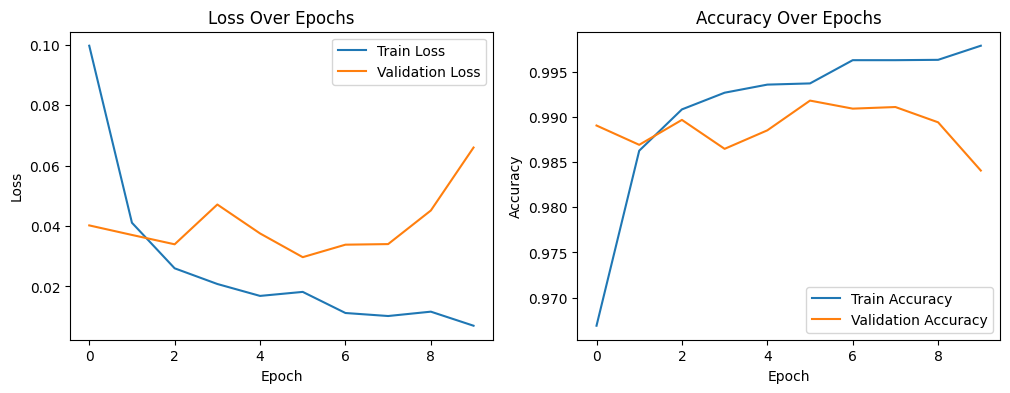

In [18]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
